In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

import jax.numpy as jnp

from pydd.analysis import calculate_SNR
from pydd.binary import get_dL_iota, get_M_chirp

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
f_c = get_f_isco(1e5 * MSUN)
M_chirp_min = 10 * MSUN  # get_M_chirp(1e3 * MSUN, 1 * MSUN)
M_chirp_max = 2000 * MSUN  # get_M_chirp(1e5 * MSUN, 1e2 * MSUN)
dL_min = 1e6 * PC
dL_max = 10e9 * PC

M_chirps = jnp.geomspace(M_chirp_min, M_chirp_max, 50)
dLs = jnp.geomspace(dL_min, dL_max, 48)

snrs = np.zeros([len(M_chirps), len(dLs)])
f_ls = np.zeros([len(M_chirps), len(dLs)])

for i, M_chirp in enumerate(tqdm(M_chirps)):
    for j, dL in enumerate(dLs):
        dd_v = VacuumBinary(M_chirp, 0., 0., get_dL_iota(dL, 0.), f_c)
        f_l = root_scalar(
            lambda f: t_to_c(f, dd_v) - t_obs_lisa,
            bracket=(1e-3, 1e-1),
            rtol=1e-15,
            xtol=1e-100,
        ).root
        f_ls[i, j] = f_l
        snrs[i, j] = calculate_SNR(dd_v, f_l, f_c, 3000)

  0%|          | 0/50 [00:00<?, ?it/s]

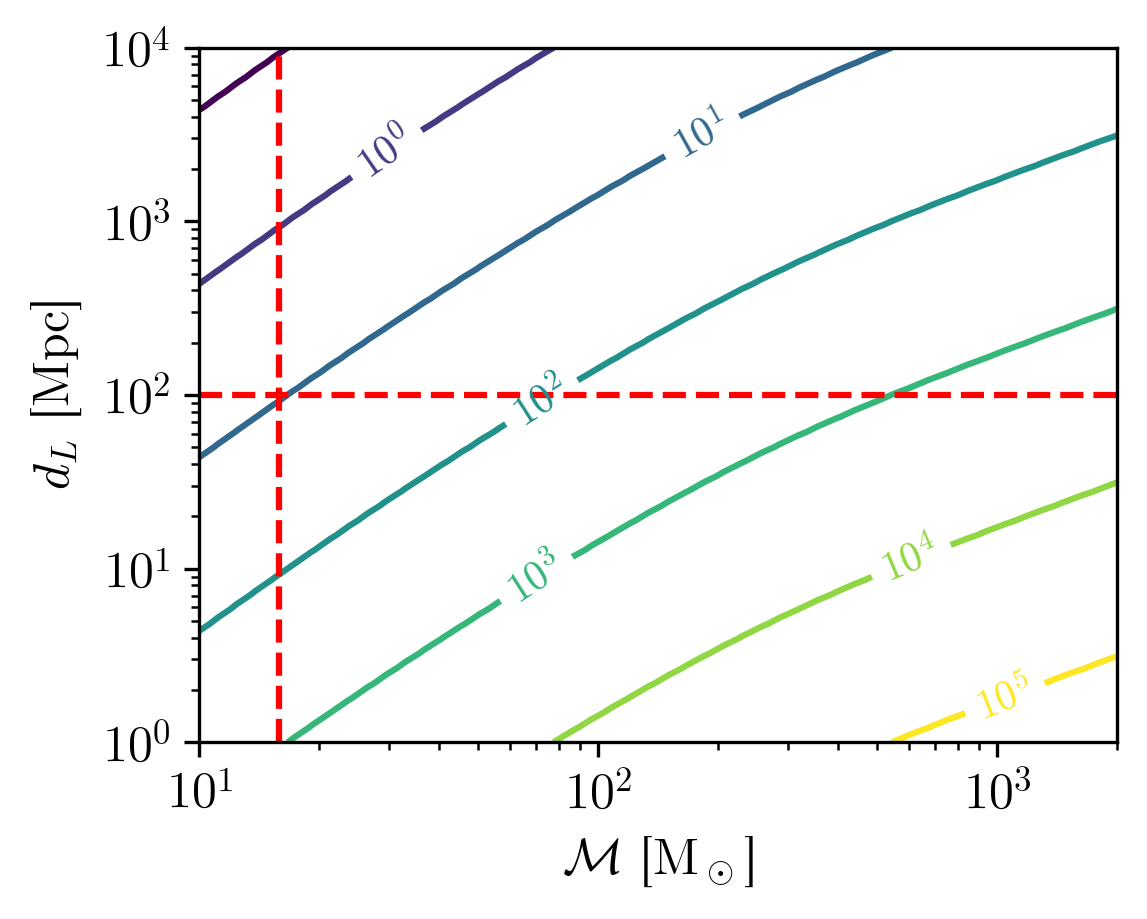

In [82]:
plt.figure(figsize=(4, 3.25))

plt.axvline(get_M_chirp(1e3, 1), color="r", linestyle="--")
plt.axhline(1e8 / 1e6, color="r", linestyle="--")
plt.xscale("log")
plt.yscale("log")
cs = plt.contour(
    M_chirps / MSUN,
    dLs / (1e6 * PC),
    jnp.log10(snrs.T),
    levels=jnp.linspace(-1, 5, 7).round(),
)
plt.clabel(cs, inline=True, fontsize=10, fmt=r"$10^{%i}$")
plt.xlabel(r"$\mathcal{M}$ [M$_\odot$]")
plt.ylabel(r"$d_L$ [Mpc]")
plt.tight_layout()

plt.savefig("figures/snrs.png")
plt.savefig("figures/snrs.pdf")